# Document Classification Example

 inspired by [Hierarchical Attention Networks for Document Classification](https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf)
 
 Using **Word attention** and **Sentence Attention** and applied for **Document** classification

In [0]:
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Embedding,Input,Bidirectional,TimeDistributed,Activation,Lambda,Multiply,Dropout
from keras.layers import LSTM,GRU
import keras.backend as K
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [11]:
data_path ='labeledTrainData.tsv'
os.listdir('input')

FileNotFoundError: ignored

In [9]:
data_train = pd.read_csv(data_path, sep='\t')

FileNotFoundError: ignored

In [0]:
INDEX_FROM=3   

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}

In [32]:
num=12
orig_sen = [id_to_word[id] for id in x_train[num]]
print('元文章')
print(' '.join(orig_sen))

元文章
<START> i love cheesy horror flicks i don't care if the acting is sub par or whether the monsters look corny i liked this movie except for the bewildered feeling all the way from the beginning of the film to the very end look i don't need a 10 page dissertation or a sign with big letters explaining a plot to me but dark floors takes the what is this movie about thing to a whole new annoying level what is this movie about br br this isn't exceptionally scary or thrilling but if you have an hour and a half to kill and or you want to end up feeling frustrated and confused rent this winner


# モデルの構築

In [0]:
#---------WordEmbedding-----------

maxlen=80  #文章内の単語数
max_features = 128 # 総単語数

hid_dim = 64  #隠れ層の次元数
embed_size = 128 #単語の埋め込み次元数
att_dim = 32  # attentionの計算のための全結合層における出力の次元
drop =0.5 #Dropout
out_size=1 # 最終出力数

#---------SentenceEmbedding-----------

doc_len=3 #1Documentに最大何文含まれて入るか
hid_dim2 = 64  #隠れ層の次元数
att_dim2 = 32  # attentionの計算のための全結合層における出力の次元


In [0]:
inputs =Input(shape=(maxlen,))
emb= Embedding(max_features, embed_size)(inputs)  #Embedding層

state = Bidirectional(GRU(hid_dim, return_sequences=True))(emb)  #GRUかLSTM

#-------  Word Attention  ----
u_it = TimeDistributed(Dense(att_dim, activation='tanh'),name='T1')(state)
score = TimeDistributed(Dense(1),name='T2')(u_it)
score_ = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], maxlen)))(score)
alpha=Activation('softmax')(score_)
alpha_ = Lambda(lambda x: K.expand_dims(x))(alpha)

alphahs=Multiply(name='attention_mul')([alpha_,state])
s = Lambda(lambda x: K.sum(x, axis=1))(alphahs)
#-----------------------------------

sent_Encoder = Model(inputs, s)

In [0]:
doc_input = Input(shape=(doc_len,maxlen))
encoded_sent = TimeDistributed(sent_Encoder)(doc_input)

state2= Bidirectional(GRU(hid_dim2, return_sequences=True))(encoded_sent)

#-------  Sentence Attention  ----
u_it2 = TimeDistributed(Dense(att_dim2, activation='tanh'),name='T1')(state2)
score2 = TimeDistributed(Dense(1),name='T2')(u_it2)
score_2 = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], 3)))(score2)
alpha2=Activation('softmax')(score_2)
alpha_2 = Lambda(lambda x: K.expand_dims(x))(alpha2)

alphahs2=Multiply(name='attention_mul')([alpha_2,state2])
s2 = Lambda(lambda x: K.sum(x, axis=1))(alphahs2)
#-----------------------------------
preds = Dense(1, activation='softmax')(s2)
model = Model(doc_input, preds)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 3, 80)        0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 3, 128)       94657       input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 3, 128)       74112       time_distributed_1[0][0]         
__________________________________________________________________________________________________
T1 (TimeDistributed)            (None, 3, 32)        4128        bidirectional_3[0][0]            
__________________________________________________________________________________________________
T2 (TimeDi

In [0]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
epochs = 2
batch_size = 32

In [0]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(x_test,y_test))  


Train on 25000 samples, validate on 25000 samples
Epoch 1/2
22080/25000 [=========================>....] - ETA: 16s - loss: 0.5522 - acc: 0.7110

25000/25000 [==============================] - 173s 7ms/step - loss: 0.5314 - acc: 0.7250 - val_loss: 0.3651 - val_acc: 0.8413
Epoch 2/2
13280/25000 [==============>...............] - ETA: 1:05 - loss: 0.2911 - acc: 0.8843

25000/25000 [==============================] - 171s 7ms/step - loss: 0.2909 - acc: 0.8822 - val_loss: 0.3533 - val_acc: 0.8461


# Attentionの可視化

In [0]:
INDEX_FROM=3   

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}

In [0]:
num=12
orig_sen = [id_to_word[id] for id in x_test[num]]
print('元文章')
print(' '.join(orig_sen))
print('正解ラベル')
print(y_test[num])

元文章
mildly gory moments but nothing worth the effort of watching the film i wouldn't say in fact aside from the above mentioned cameos this entire movie is really quite stale and turgid with characters that couldn't get <UNK> quick enough for my liking and an unfortunate lack of any real interest i didn't even find it fun in a laughable bad movie sense which is rare for me since i love a lot of pretty crummy films i'd say avoid
正解ラベル
0


<function matplotlib.pyplot.plot>

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['AppleMyungjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


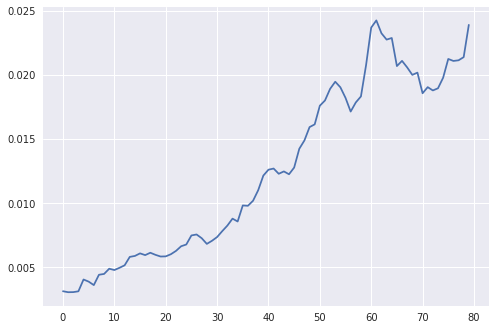

In [0]:
# attention weight
get_Attention = K.function([model.layers[0].input],
                                  [model.layers[6].output])
attention = get_Attention([x_test[num:num+1]])[0][0]
attention.shape

plt.plot(attention)
plt.plot

In [0]:
# attention　weightの合計が１の確
np.sum(attention)

1.0000001

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['AppleMyungjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


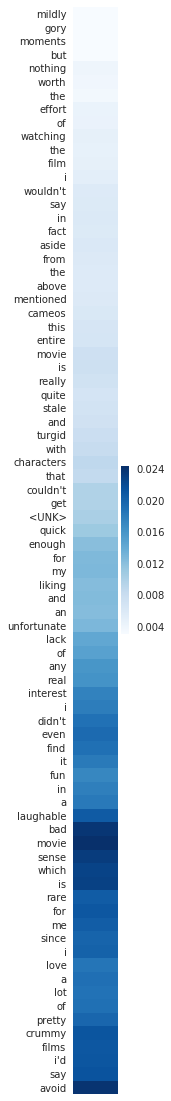

In [0]:
plt.figure(figsize=(1, 20))
sns.set(font='AppleMyungjo')
sns.heatmap(attention[:,np.newaxis],cmap="Blues",xticklabels=False,yticklabels=orig_sen)
plt.show()